In [1]:
!pip install segmentation-models-pytorch
!pip install opencv-python numpy matplotlib scikit-image pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import os
import json
import shutil
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
import matplotlib.pyplot as plt
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.cluster import DBSCAN
from PIL import Image, ImageDraw
from tqdm import tqdm
import warnings
from pathlib import Path
from collections import defaultdict
import random
import time
import gc
from torch.nn import functional as F
import uuid
warnings.filterwarnings('ignore')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [35]:
clip_directories = {
"Clip1": { "image": "/content/drive/MyDrive/Annotated_Files/Clip1/images",
	         "json": "/content/drive/MyDrive/Annotated_Files/Clip1/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip1/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip1/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip1/visualizations"},


"Clip2": { "image": "/content/drive/MyDrive/Annotated_Files/Clip2/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip2/jsons",
           "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip2/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip2/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip2/visualizations"},

"Clip3": { "image": "/content/drive/MyDrive/Annotated_Files/Clip3/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip3/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip3/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip3/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip3/visualizations"},

"Clip4": { "image": "/content/drive/MyDrive/Annotated_Files/Clip4/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip4/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip4/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip4/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip4/visualizations"},

"Clip5": { "image": "/content/drive/MyDrive/Annotated_Files/Clip5/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip5/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip5/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip5/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip5/visualizations"},

"Clip6": { "image": "/content/drive/MyDrive/Annotated_Files/Clip6/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip6/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip6/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip6/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip6/visualizations"},

"Clip7": { "image": "/content/drive/MyDrive/Annotated_Files/Clip7/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip7/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip7/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip7/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip7/visualizations"},

"Clip8": { "image": "/content/drive/MyDrive/Annotated_Files/Clip8/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip8/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip8/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip8/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip8/visualizations"},

"Clip9": { "image": "/content/drive/MyDrive/Annotated_Files/Clip9/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip9/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip9/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip9/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip9/visualizations"},

"Clip10": { "image": "/content/drive/MyDrive/Annotated_Files/Clip10/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip10/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip10/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip10/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip10/visualizations"},

"Clip11": { "image": "/content/drive/MyDrive/Annotated_Files/Clip11/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip11/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip11/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip11/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip11/visualizations"},

"Clip12": { "image": "/content/drive/MyDrive/Annotated_Files/Clip12/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip12/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip12/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip12/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip12/visualizations"},

"Clip13": { "image": "/content/drive/MyDrive/Annotated_Files/Clip13/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip13/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip13/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip13/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip13/visualizations"},

"Clip14": { "image": "/content/drive/MyDrive/Annotated_Files/Clip14/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip14/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip14/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip14/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip14/visualizations"},

"Clip15": { "image": "/content/drive/MyDrive/Annotated_Files/Clip15/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip15/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip15/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip15/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip15/visualizations"},

"Clip16": { "image": "/content/drive/MyDrive/Annotated_Files/Clip16/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip16/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip16/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip16/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip16/visualizations"},


"Clip17": { "image": "/content/drive/MyDrive/Annotated_Files/Clip17/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip17/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip17/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip17/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip17/visualizations"},

"Clip18": { "image": "/content/drive/MyDrive/Annotated_Files/Clip18/images",
           "json": "/content/drive/MyDrive/Annotated_Files/Clip18/jsons",
	         "binary_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip18/masks/binary",
	         "instance_mask": "/content/drive/MyDrive/Annotated_Files/Output/Clip18/masks/instance",
	         "visualization": "/content/drive/MyDrive/Annotated_Files/Output/Clip18/visualizations"},

                      }


# Set output directory
output_folder = "/content/drive/MyDrive/Annotated_Files/Output"
video_path = "/content/drive/MyDrive/Annotated_Files/VideoTest.mp4"

In [37]:
# Configuration - Much lighter settings
class Config:
    def __init__(self):
        self.img_height = 128  # Reduced from 256
        self.img_width = 256   # Reduced from 512
        self.batch_size = 1    # Reduced from 4
        self.learning_rate = 1e-3
        self.epochs = 30       # Reduced from 50
        self.sequence_length = 3  # Reduced from 5
        self.num_classes = 2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

config = Config()

Using device: cuda


In [38]:
# 1. DATASET SPLITTING - Fixed to handle small datasets
def split_dataset(clip_directories, test_size=0.2, val_size=0.1, min_files=10):
    """Split dataset into train, validation, and test sets"""
    all_files = []

    for clip_name, paths in clip_directories.items():
        if clip_name == "Clipn":  # Skip template
            continue

        image_dir = paths["image"]
        json_dir = paths["json"]
        binary_mask_dir = paths["binary_mask"]

        print(f"Checking {clip_name}...")
        print(f"  Image dir exists: {os.path.exists(image_dir)}")
        print(f"  JSON dir exists: {os.path.exists(json_dir)}")
        print(f"  Binary mask dir exists: {os.path.exists(binary_mask_dir)}")

        if os.path.exists(image_dir) and os.path.exists(json_dir) and os.path.exists(binary_mask_dir):
            # Get all image files
            image_files = glob(os.path.join(image_dir, "*.jpg")) + glob(os.path.join(image_dir, "*.png"))
            print(f"  Found {len(image_files)} image files")

            for img_path in image_files:
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                json_path = os.path.join(json_dir, base_name + ".json")
                binary_mask_path = os.path.join(binary_mask_dir, base_name + "_binary.png")

                if os.path.exists(json_path) and os.path.exists(binary_mask_path):
                    all_files.append({
                        'image': img_path,
                        'json': json_path,
                        'binary_mask': binary_mask_path,
                        'clip': clip_name
                    })

    print(f"Total files found: {len(all_files)}")

    if len(all_files) < min_files:
        print(f"Warning: Only {len(all_files)} files found. Using simple split.")
        # For small datasets, use simple split
        if len(all_files) < 3:
            return all_files, [], []  # All train, no val/test
        elif len(all_files) < 6:
            train_files = all_files[:-1]
            val_files = []
            test_files = [all_files[-1]]
        else:
            train_size = max(1, int(len(all_files) * 0.7))
            val_size = max(1, int(len(all_files) * 0.15))
            train_files = all_files[:train_size]
            val_files = all_files[train_size:train_size+val_size]
            test_files = all_files[train_size+val_size:]
    else:
        # Normal split for larger datasets
        train_files, temp_files = train_test_split(all_files, test_size=test_size + val_size, random_state=42)
        if len(temp_files) >= 2:
            val_files, test_files = train_test_split(temp_files, test_size=test_size/(test_size + val_size), random_state=42)
        else:
            val_files = []
            test_files = temp_files

    print(f"Split - Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

    return train_files, val_files, test_files

In [39]:
# 2. DATASET CLASS - Simplified
class LaneDataset(Dataset):
    def __init__(self, file_list, sequence_length=3, transform=None, is_sequence=False):
        self.file_list = file_list
        self.sequence_length = sequence_length
        self.transform = transform
        self.is_sequence = is_sequence

        # For simplicity, we'll use single frames mostly to reduce memory
        if is_sequence and len(file_list) > sequence_length:
            self.sequences = self._create_sequences()
        else:
            self.sequences = file_list
            self.is_sequence = False

    def _create_sequences(self):
        """Create sequences grouped by clip for LSTM"""
        clip_files = defaultdict(list)

        # Group files by clip
        for file_info in self.file_list:
            clip_files[file_info['clip']].append(file_info)

        # Sort files within each clip by filename
        for clip in clip_files:
            clip_files[clip].sort(key=lambda x: os.path.basename(x['image']))

        sequences = []
        for clip, files in clip_files.items():
            if len(files) >= self.sequence_length:
                for i in range(len(files) - self.sequence_length + 1):
                    sequences.append(files[i:i + self.sequence_length])

        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        try:
            if self.is_sequence:
                sequence_files = self.sequences[idx]
                images = []
                masks = []

                for file_info in sequence_files:
                    # Load and process image
                    image = cv2.imread(file_info['image'])
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (config.img_width, config.img_height))

                    # Load binary mask
                    mask = cv2.imread(file_info['binary_mask'], cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        continue
                    mask = cv2.resize(mask, (config.img_width, config.img_height))
                    mask = (mask > 127).astype(np.float32)

                    image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                    mask = torch.from_numpy(mask).float()

                    images.append(image)
                    masks.append(mask)

                if len(images) == 0:
                    # Fallback to zeros if no valid images
                    images = [torch.zeros(3, config.img_height, config.img_width)]
                    masks = [torch.zeros(config.img_height, config.img_width)]

                return torch.stack(images), torch.stack(masks)
            else:
                # Single frame
                file_info = self.sequences[idx]
                image = cv2.imread(file_info['image'])
                if image is None:
                    image = np.zeros((config.img_height, config.img_width, 3), dtype=np.uint8)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (config.img_width, config.img_height))

                mask = cv2.imread(file_info['binary_mask'], cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    mask = np.zeros((config.img_height, config.img_width), dtype=np.uint8)
                else:
                    mask = cv2.resize(mask, (config.img_width, config.img_height))
                    mask = (mask > 127).astype(np.float32)

                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask = torch.from_numpy(mask).float()

                return image, mask
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            # Return dummy data
            image = torch.zeros(3, config.img_height, config.img_width)
            mask = torch.zeros(config.img_height, config.img_width)
            return image, mask


In [40]:
# 3. ULTRA-LIGHTWEIGHT MODEL ARCHITECTURE
class TinyEncoder(nn.Module):
    """Ultra-lightweight encoder"""
    def __init__(self, in_channels=3):
        super(TinyEncoder, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64x128
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x64
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16x32
        )

    def forward(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        c3 = self.conv3(c2)
        return c1, c2, c3

class TinyDecoder(nn.Module):
    """Ultra-lightweight decoder"""
    def __init__(self, num_classes=2):
        super(TinyDecoder, self).__init__()

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(16, 16, 2, stride=2)
        self.final = nn.Conv2d(16, num_classes, 1)

    def forward(self, c1, c2, c3):
        x = self.up1(c3)
        x = torch.cat([x, c2], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, c1], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = self.final(x)
        return x

class TinyLaneNet(nn.Module):
    """Ultra-lightweight LaneNet"""
    def __init__(self, num_classes=2):
        super(TinyLaneNet, self).__init__()
        self.encoder = TinyEncoder()
        self.decoder = TinyDecoder(num_classes)

    def forward(self, x):
        c1, c2, c3 = self.encoder(x)
        out = self.decoder(c1, c2, c3)
        return out

class TinyLaneNetLSTM(nn.Module):
    """Ultra-lightweight LaneNet + LSTM"""
    def __init__(self, num_classes=2, hidden_size=32):
        super(TinyLaneNetLSTM, self).__init__()
        self.lanenet = TinyLaneNet(num_classes)
        self.hidden_size = hidden_size

        # Much smaller LSTM
        self.lstm = nn.LSTM(
            input_size=64 * 16 * 32,  # Flattened feature size
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        self.final_conv = nn.Conv2d(num_classes + hidden_size, num_classes, 1)

    def forward(self, x):
        if len(x.shape) == 4:  # Single frame
            return self.lanenet(x)

        # Sequence processing
        batch_size, seq_len = x.shape[:2]

        lstm_features = []
        segmentation_outputs = []

        for i in range(seq_len):
            frame = x[:, i]
            c1, c2, c3 = self.lanenet.encoder(frame)
            seg_out = self.lanenet.decoder(c1, c2, c3)

            lstm_features.append(c3.view(batch_size, -1))
            segmentation_outputs.append(seg_out)

        # LSTM processing
        lstm_input = torch.stack(lstm_features, dim=1)
        lstm_out, _ = self.lstm(lstm_input)

        # Use last frame for final prediction
        temporal_features = lstm_out[:, -1].unsqueeze(-1).unsqueeze(-1)
        temporal_features = temporal_features.expand(-1, -1, config.img_height, config.img_width)

        last_seg = segmentation_outputs[-1]
        combined = torch.cat([last_seg, temporal_features], dim=1)
        final_output = self.final_conv(combined)

        return final_output, segmentation_outputs

In [41]:
# 4. TRAINING - Fixed for empty validation sets
def train_model(model, train_loader, val_loader, epochs=20):
    """Train the model with proper error handling"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    train_losses = []
    val_losses = []

    print(f"Train loader size: {len(train_loader)}")
    print(f"Val loader size: {len(val_loader) if val_loader else 0}")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_idx, (images, masks) in enumerate(train_loader):
            try:
                images, masks = images.to(config.device), masks.to(config.device)

                optimizer.zero_grad()

                if len(images.shape) == 5 and images.shape[1] > 1:  # Sequence data
                    final_output, _ = model(images)
                    target = masks[:, -1].long()
                else:  # Single frame
                    if len(images.shape) == 5:
                        images = images[:, 0]  # Take first frame
                        masks = masks[:, 0]
                    final_output = model(images)
                    target = masks.long()

                loss = criterion(final_output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_batches += 1

                if batch_idx % 5 == 0:
                    print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Validation
        val_loss = 0.0
        val_batches = 0

        if val_loader and len(val_loader) > 0:
            model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    try:
                        images, masks = images.to(config.device), masks.to(config.device)

                        if len(images.shape) == 5 and images.shape[1] > 1:
                            final_output, _ = model(images)
                            target = masks[:, -1].long()
                        else:
                            if len(images.shape) == 5:
                                images = images[:, 0]
                                masks = masks[:, 0]
                            final_output = model(images)
                            target = masks.long()

                        loss = criterion(final_output, target)
                        val_loss += loss.item()
                        val_batches += 1

                    except Exception as e:
                        print(f"Error in validation: {e}")
                        continue

        # Calculate average losses
        avg_train_loss = train_loss / max(train_batches, 1)
        avg_val_loss = val_loss / max(val_batches, 1) if val_batches > 0 else 0.0

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [42]:
# 5. INFERENCE AND VISUALIZATION - Simplified
def visualize_prediction(image, mask, prediction, save_path=None):
    """Visualize the prediction results"""
    try:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Original image
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Ground truth mask
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        # Prediction
        if isinstance(prediction, torch.Tensor):
            if prediction.dim() > 2:
                prediction = torch.softmax(prediction, dim=0)
                prediction = prediction[1].cpu().numpy()  # Lane class
            else:
                prediction = prediction.cpu().numpy()
        axes[2].imshow(prediction, cmap='hot')
        axes[2].set_title('Prediction')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error in visualization: {e}")


In [43]:
def create_lane_overlay(image, prediction, alpha=0.6):
    """Create overlay visualization"""
    try:
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()

        if isinstance(prediction, torch.Tensor):
            if prediction.dim() > 2:
                prediction = torch.softmax(prediction, dim=0)
                prediction = prediction[1].cpu().numpy()
            else:
                prediction = prediction.cpu().numpy()

        # Ensure proper image format
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

        # Create colored overlay
        overlay = np.zeros_like(image)
        overlay[:, :, 2] = (prediction * 255).astype(np.uint8)  # Blue overlay

        # Blend with original image
        result = cv2.addWeighted(image, 1-alpha, overlay, alpha, 0)

        return result
    except Exception as e:
        print(f"Error creating overlay: {e}")
        return image


In [44]:
# 6. VIDEO TESTING
def process_video(model, video_path, output_path, sequence_length=5):
    """Process video and create lane detection visualization"""
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    model.eval()
    frame_buffer = []

    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess frame
            processed_frame = cv2.resize(frame, (config.img_width, config.img_height))
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            tensor_frame = torch.from_numpy(processed_frame.transpose(2, 0, 1)).float() / 255.0

            frame_buffer.append(tensor_frame)

            if len(frame_buffer) >= sequence_length:
                # Create sequence
                sequence = torch.stack(frame_buffer[-sequence_length:]).unsqueeze(0).to(config.device)

                # Predict
                if hasattr(model, 'lstm'):  # LSTM model
                    prediction, _ = model(sequence)
                else:  # Single frame model
                    prediction = model(tensor_frame.unsqueeze(0).to(config.device))

                # Create visualization
                pred_resized = F.interpolate(prediction, size=(height, width), mode='bilinear')
                overlay = create_lane_overlay(
                    torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).transpose(2, 0, 1)).float() / 255.0,
                    pred_resized[0]
                )

                # Convert back to BGR for video writing
                overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
                out.write(overlay_bgr)
            else:
                # Not enough frames yet, write original
                out.write(frame)

    cap.release()
    out.release()
    print(f"Video processing complete. Output saved to: {output_path}")


In [45]:
# 1. Split dataset
print("Splitting dataset...")
train_files, val_files, test_files = split_dataset(clip_directories)


Splitting dataset...
Checking Clip1...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 26 image files
Checking Clip2...
  Image dir exists: False
  JSON dir exists: False
  Binary mask dir exists: False
Checking Clip3...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 12 image files
Checking Clip4...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 11 image files
Checking Clip5...
  Image dir exists: False
  JSON dir exists: False
  Binary mask dir exists: False
Checking Clip6...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 12 image files
Checking Clip7...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 40 image files
Checking Clip8...
  Image dir exists: True
  JSON dir exists: True
  Binary mask dir exists: True
  Found 19 image files
Checking Clip9...
  Image dir exists: True
  JSON d

In [46]:
# 2. Create datasets and dataloaders
print("Creating datasets...")
train_dataset = LaneDataset(train_files, sequence_length=config.sequence_length, is_sequence=False)

val_dataset = None
val_loader = None
if len(val_files) > 0:
    val_dataset = LaneDataset(val_files, sequence_length=config.sequence_length, is_sequence=False)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

test_dataset = None
test_loader = None
if len(test_files) > 0:
    test_dataset = LaneDataset(test_files, is_sequence=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)

Creating datasets...


In [47]:
# 3. Initialize model
print("Initializing ultra-lightweight model...")
model = TinyLaneNetLSTM(num_classes=config.num_classes).to(config.device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

Initializing ultra-lightweight model...
Model parameters: 4,257,080


In [48]:
# 4. Train model
print("Training model...")
train_losses, val_losses = train_model(model, train_loader, val_loader, config.epochs)

# Create output directory
os.makedirs('/content/drive/MyDrive/Annotated_Files/Output', exist_ok=True)

Training model...
Train loader size: 232
Val loader size: 33
Epoch 0, Batch 0, Loss: 0.6466
Epoch 0, Batch 5, Loss: 0.5864
Epoch 0, Batch 10, Loss: 0.5251
Epoch 0, Batch 15, Loss: 0.4623
Epoch 0, Batch 20, Loss: 0.4129
Epoch 0, Batch 25, Loss: 0.3711
Epoch 0, Batch 30, Loss: 0.3023
Epoch 0, Batch 35, Loss: 0.2772
Epoch 0, Batch 40, Loss: 0.2190
Epoch 0, Batch 45, Loss: 0.2070
Epoch 0, Batch 50, Loss: 0.1602
Epoch 0, Batch 55, Loss: 0.1418
Epoch 0, Batch 60, Loss: 0.1219
Epoch 0, Batch 65, Loss: 0.1078
Epoch 0, Batch 70, Loss: 0.0969
Epoch 0, Batch 75, Loss: 0.0871
Epoch 0, Batch 80, Loss: 0.0805
Epoch 0, Batch 85, Loss: 0.0811
Epoch 0, Batch 90, Loss: 0.0676
Epoch 0, Batch 95, Loss: 0.0666
Epoch 0, Batch 100, Loss: 0.0551
Epoch 0, Batch 105, Loss: 0.0553
Epoch 0, Batch 110, Loss: 0.0602
Epoch 0, Batch 115, Loss: 0.0559
Epoch 0, Batch 120, Loss: 0.0560
Epoch 0, Batch 125, Loss: 0.0622
Epoch 0, Batch 130, Loss: 0.0525
Epoch 0, Batch 135, Loss: 0.0735
Epoch 0, Batch 140, Loss: 0.0903
Epoc

In [49]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Annotated_Files/Output/tiny_lanenet_model.pth')
print("Model saved!")

Model saved!


Testing model...


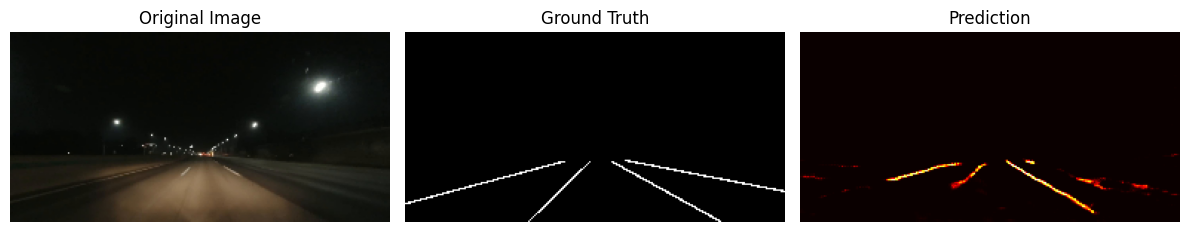

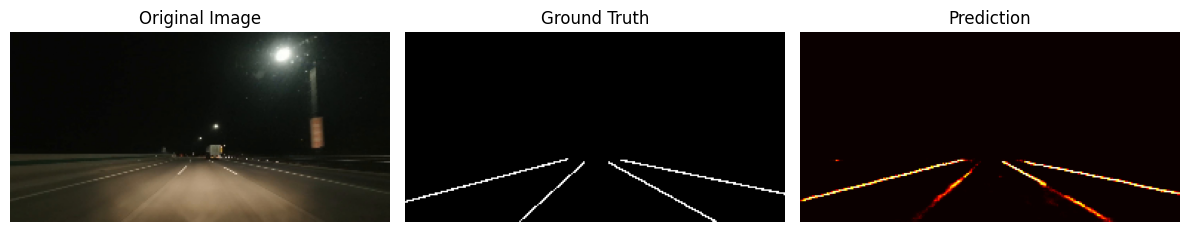

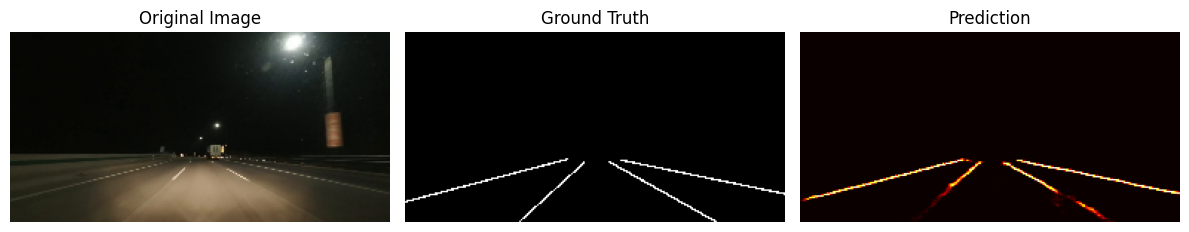

Pipeline complete!


In [50]:
# 5. Test and visualize
if test_loader:
    print("Testing model...")
    model.eval()

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            if i >= 3:  # Show first 3 test examples
                break

            try:
                image, mask = image.to(config.device), mask.to(config.device)
                prediction = model(image)

                visualize_prediction(
                    image[0],
                    mask[0],
                    prediction[0],
                    f'/content/drive/MyDrive/Annotated_Files/Output/test_result_{i}.png'
                )
            except Exception as e:
                print(f"Error in testing: {e}")
                continue

print("Pipeline complete!")

In [51]:
# 6. Process video
video_path = "/content/drive/MyDrive/Annotated_Files/VideoTest.mp4"
output_video_path = "/content/drive/MyDrive/Annotated_Files/Output/lane_detection_result.mp4"

if os.path.exists(video_path):
    print("Processing video...")
    process_video(model, video_path, output_video_path)
else:
    print("Video file not found, skipping video processing")

print("Pipeline complete!")

Processing video...
Video processing complete. Output saved to: /content/drive/MyDrive/Annotated_Files/Output/lane_detection_result.mp4
Pipeline complete!
